# RL coursework, part IV (30 pts in total)

---

**Name:** Harry Yao

**SN:** 20012409

---

**Due date:** *April 10th, 2025*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

----
**Reminder of copyrights**

Copyrights protect this code/content and distribution or usages of it (or parts of it) without permission is prohibited. This includes uploading it and usage of it in training in any LLMs systems.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)

## Section A: Multi-step + offpolicy in practice [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency.

In [2]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))

  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [3]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections, so that
  the return G_t is corrected with the full importance-sampling correction of
  the rest of the trajectory.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rho = pi/mu
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    cumulative_rho = np.prod(rho[t:])
    if t == T - 1:
      G[t] = (r[t] + d[t]*v[t + 1]) * cumulative_rho
    else:
      G[t] = (r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])) * cumulative_rho
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  rho = pi/mu
  G = np.zeros((T,))
  for t in reversed(range(T)):
    if t == T - 1:
      G[t] = r[t] + d[t] * v[t + 1] * rho[t]
    else:
      G[t] = r[t] + d[t] * ((1 - l) * v[t + 1] + l * G[t + 1]) * rho[t]
  v = v[:-1]
  return (1 - l)*v + l*G

def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  rho = pi/mu
  G = np.zeros((T,))
  for t in reversed(range(T)):
    if t == T - 1:
        G[t] = r[t] + d[t] * rho[t] * v[t + 1] - d[t] * (rho[t] - 1) * v[t + 1]
    else:
        G[t] = (r[t] + d[t] * rho[t] * ((1 - l) * v[t + 1] + l * G[t + 1]) - d[t] * (rho[t] - 1) * v[t + 1])
  v = v[:-1]
  return (1 - l)*v + l*G

def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with
  1. per-decision importance-sampling corrections, and
  2. control variates, and
  3. adaptive bootstrapping.

  Implement the adaptive bootstrapping with an *additional* trace parameter
  lambda, such that lambda_t = lambda * min(1, 1/rho_t).
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  lam = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  rho = pi/mu
  G = np.zeros((T,))
  for t in reversed(range(T)):
    lambda_t = lam * min(1, 1/rho[t])
    if t == T - 1:
       G[t] = r[t] + d[t] * rho[t] * v[t + 1] - d[t] * (rho[t] - 1) * v[t + 1]
    else:
        G[t] = (r[t] + d[t] * rho[t] * ((1 - lambda_t) * v[t + 1] + lambda_t * G[t + 1]) - d[t] * (rho[t] - 1) * v[t + 1])
  v = v[:-1]
  return (1 - lam) * v + lam * G


In [4]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...

  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right,
  rewards[-1] = np.sum(actions)  # extra final reward for going right

  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities

  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



[      20.26  15475460.233      121.691       19.926        5.873]


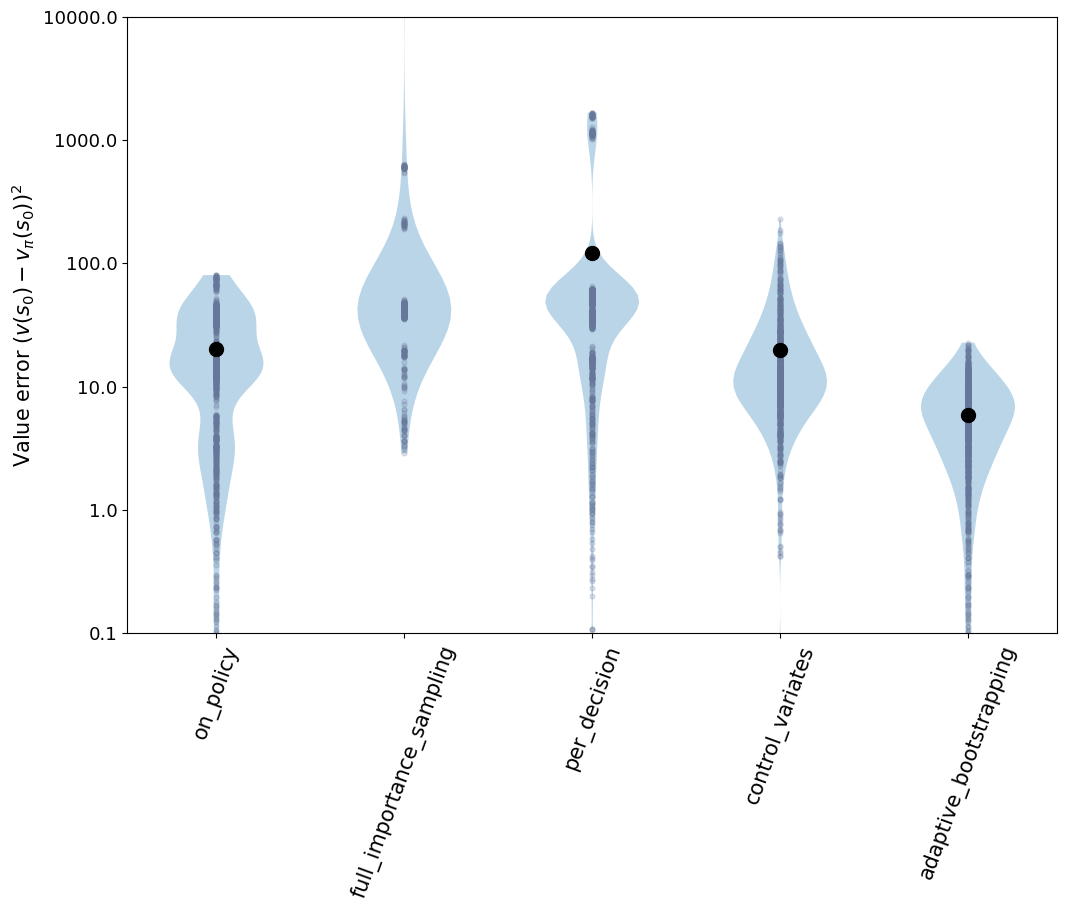

In [5]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.

Rank from lowest to highest value error:

1. adaptive_bootstrapping (lowest error)

2. control_variates

3. on_policy

4. per_decision

5. full_importance_sampling (highest error)

Explaination:

- Adaptive bootstrapping combines per-decision corrections, control variates and adjusts the bootstrapping factor dynamically based on importance weights, achieving the best trade-off between bias and variance, result as the lowest error.

- Control variates reduce variance by subtracting expected value under behavior policy, improving over both per-decision and on-policy estimators.

- On-policy avoids importance sampling entirely. However, lacking correction of off-policy data leads to bias.

- Per-decision importance sampling applies correction locally at each step for improvement, but still suffers by variance.

- Full importance sampling has the highest variance due to the product of importance weights over time, which can explode easily and destabilize learning. This mechansim leads to the worst performance.




### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

Yes.Even though adaptive_bootstrapping has the lowest average value error, it may not always be the best choice for learning:
1. Adaptive_bootstrapping's reliance on dynamic λₜ can introduce instability during training, especially when importance weights are small.
2. Complex computation and sensitivity on small fluctuations in ρₜ leads to negative learning effect.
3. Although adaptive_bootstrapping reduces estimation error, it may introduce high variance during updates.
4. Lower value error does not always mean better policy learning. Simpler estimators may perform better in practice.
5. High-variance updates may lead to unstable learning.

## Section B: Potential different algorithms/updates [19 points total]
 Consider a MDP $M = (\mathbb{S}, \mathbb{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)

ii) Under which conditions, would the above process converge to the optimal value function $q_*$ ? (2 points)

i) Yes, the value function will converge under suitable conditions. Uunder following assumptions, the value function $q_t$ will converge:


#### Assumptions

- The state space S and action space A are finite.
- The learning rate satisfies the **Robbins-Monro conditions**:

$$
\sum_t \alpha_t(s,a) = \infty, \quad \sum_t \alpha_t^2(s,a) < \infty
$$

- The behaviour policy $ \mu $ ensures sufficient exploration:

$$
\mu(a|s) > 0 \quad \forall (s,a) \in \mathcal{S} \times \mathcal{A}
$$

- The reward function $ R(s,a) $ is bounded, and the initial value $ q_0(s,a) $ is bounded.


#### TD Update Rule

The update rule is:

$$
q_{t+1}(S_t, A_t) = q_t(S_t, A_t) + \alpha_t \left[ R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q_t(S_{t+2}, a) - q_t(S_t, A_t) \right]
$$

This defines a stochastic approximation process. According to **Jaakkola et al. (1994)**, convergence is guaranteed under the assumptions above because:

- The expected update operator is a contraction:
  
$$
\| \mathbb{E}[F_t] \|_\infty \leq \gamma^2 \| q_t - q^* \|_\infty
$$

- The variance of the update is bounded.
- All state–action pairs are visited infinitely often.


**Convergence Point**:

$$
q^\dagger = (\mathcal{T}_Q^*)^2 q
$$

This is the fixed point of the **double application of the Bellman optimality operator** $ \mathcal{T}_Q^* $.  
It is **not necessarily equal** to the true optimal value \$ q^* $, but it is the stable fixed point under this TD update rule.

---

ii) Following TD update process will converge to the optimal value function $q^*$:
- The **behavior policy $\mu$ is the same as the target policy** or sufficient **off-policy corrections** used to account for the difference between behavior and target policy.
- The **reward function $R(s, a)$** is bounded.
- The **state space $\mathcal{S}$** and **action space $\mathcal{A}$** are finite.
- The **learning rate $\alpha_t(s, a)$** satisfies the Robbins–Monro conditions:
  $$
  \sum_t \alpha_t(s, a) = \infty, \quad \sum_t \alpha_t^2(s, a) < \infty
  $$

Under these conditions, the value function $q_t(s,a)$ converges to the **true optimal value function** $q^*$, which is the unique fixed point of the Bellman optimality operator:
$$
\mathcal{T}_Q^* f(s, a) = R(s, a) + \gamma \sum_{s'} p(s'|s,a) \max_{a'} f(s', a')
$$

### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathbb{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)
* ii) How does the variance of this update compare to the one induced by the error in Q2.1? (3 points).
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$ (a and b)? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

i) No, the update using this TD error does not generally converge to the optimal value function $q^*$, although it may converge to a fixed point under standard assumptions.

#### Given TD Error with importance sampling correction):
$$
\delta_t = r(s_t, a_t) + \gamma \frac{\pi(a_{t+1} \mid s_{t+1})}{\mu(a_{t+1} \mid s_{t+1})} \left[ r(s_{t+1}, a_{t+1}) + \gamma^2 \max_a q(s_{t+2}, a) \right] - q(s_t, a_t)
$$

Update rule:
$$
q_{t+1}(s_t, a_t) = q_t(s_t, a_t) + \alpha_t \delta_t
$$

### Proof:

#### 1. Convergence in stochastic approximation sense:
Under the following conditions, convergence is guaranteed:
- Finite state/action spaces: $|\mathcal{S}| < \infty, |\mathcal{A}| < \infty$
- Robbins–Monro learning rate:
$$
\sum_t \alpha_t(s, a) = \infty, \quad \sum_t \alpha_t^2(s, a) < \infty
$$
- Sufficient exploration: $\mu(a|s) > 0 \ \forall s,a$

Then, $q_t$ converges almost surely.


#### 2. But convergence is not to $q^*$

Because the target includes importance sampling corrections and 2-step bootstrapping, it does **not** directly estimate the Bellman optimal operator $\mathcal{T}_Q^*$, but rather:
$$
q^\dagger = (\mathcal{T}_Q^*)^2 q
$$
This is not guaranteed to be equal to $q^*$, unless the behavior policy $\mu = \pi$, which convert off-policy to on-policy.

### Conclusion:

- If $\mu \ne \pi$: Converges to a biased fixed point $q^\dagger \ne q^*$
- If $\mu = \pi$: On-policy learning; converges to $q^*$

---

ii)
#### Q2.1 TD Error:

$$
\delta^{\text{Q2.1}}_t = r_t + \gamma \max_a q(s_{t+1}, a) - q(s_t, a_t)
$$

This is the standard 1-step **Q-learning** update, which has:
- **Low variance**, because it uses the greedy action $a = \arg\max_a q(s_{t+1}, a)$, avoiding stochasticity from sampling actions.
- **High bias**, especially in the off-policy setting.

#### Q2.2 TD Error (importance sampling + 2-step):

$$
\delta^{\text{Q2.2}}_t = r_t + \gamma \frac{\pi(a_{t+1} \mid s_{t+1})}{\mu(a_{t+1} \mid s_{t+1})} \left( r_{t+1} + \gamma \max_a q(s_{t+2}, a) \right) - q(s_t, a_t)
$$

This TD error:
- Involves **two steps** of sampling: from $s_{t+1}$ and $s_{t+2}$.
- Uses **importance sampling ratio** $\rho = \frac{\pi}{\mu}$, which increases variance, especially when $\mu$ is small and $\pi$ is large.
- Thus, variance is **significantly higher** than in Q2.1.


> The TD error in Q2.2 has **higher variance** than that in Q2.1, due to both the use of **importance sampling corrections** and the **multi-step target**, which compounds noise from rewards and stochastic policies.

---
iii)
Yes, it is possible to design a behaviour policy μ with lower variance than both greedy and uniform.

**ε-soft behaviour policy** defined as:

$$
\mu(a|s) = \epsilon \cdot \frac{1}{|\mathcal{A}|} + (1 - \epsilon) \cdot \pi(a|s), \quad \epsilon \in (0,1)
$$

This behaviour policy is a mixture between the target policy π and the uniform distribution.

- When ε → 0: μ → π (on-policy, lowest variance).
- When ε → 1: μ → uniform (highest variance).
- When 0 < ε < 1: importance ratios $\rho = \frac{\pi(a|s)}{\mu(a|s)}$ are smaller than with μ = uniform.

The variance of $\rho \cdot G_t$ is lower because $\rho(a|s)$ is closer to 1, reducing the effect of importance sampling, which leads to more stable learning and smaller error in off-policy updates.

Therefore, ε-soft policy perform better between exploration and low variance.
